BABY NAMES BY STATE and YEAR

Write a python code to do the following:

    1. Download and compile baby names by state dataset.
    2. Create a library class called BabyNames: a 
    
The class offers the following interfaces:
    
    a. Constructor where you pass the file location to create Pandas DataFrame.
    b. Count (state=’’, year=’’): returns the total number of births. A blank state or year should return all births of the empty input.
    c. Top10BabyNames(state=’IL’, year=2015).
    d. ChangeOfPopularity (fromYear=2014, toYear=2015, top=10): This function should lists of baby names (male or female) that showed change in popularity as follows:
        i. Names that increased in popularity
        ii. Names that decreased in popularity
        iii. Names having the same popularity

In [1]:
# Importing libraries and baby name dataset

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
import os
import pymysql
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
# Create a library class called BabyNames with the functions Constructor, Count, Top10BabyNames, ChangeOfPopularity, Top5NamesPerYear, NamePopularityPlot and NameFlip

class BabyNames:
    def __init__(self, path = '/namesbystate'): #path=?
        filepath=os.getcwd() + path #self.FILEPATH?
        allFiles = glob.glob(filepath + "/*.TXT")
        self.state_name_df = pd.concat((pd.read_csv(f, index_col=None, names=['state','sex','year','name','count']) for f in allFiles)) 
        
    def show_df(self):
        return self.state_name_df
    
    def Count(self, state="", year=""): 
        """
        returns the sum of all baby names for the given state and year combination. 
        if either is left blank it will return the sum across all.
        """

        if (state =="") & (year == ""):
            return(self.state_name_df.loc[:,'count'].sum())

        elif (state == ""):
            cond2= self.state_name_df.loc[:,'year']==year
            return(self.state_name_df.loc[cond2, 'count'].sum())  

        elif year=="":
            cond1= self.state_name_df.loc[:,'state']==state
            return(self.state_name_df.loc[cond1, 'count'].sum())

        else:
            cond1= self.state_name_df.loc[:,'state']==state
            cond2= self.state_name_df.loc[:,'year']==int(year)
            return(self.state_name_df.loc[(cond1)&(cond2), 'count'].sum())
        
    def Top10(self, state=None, year=None):      
        """
        returns the top 10 most popular names for both male and female for a given state and year.
        Not specifying either state, year, or either will return the rank among all. 
        """
       
        cond1= (self.state_name_df['state'] == state) | (state is None)
        cond2= (self.state_name_df['year'] == year) | (year is None)
        df= self.state_name_df[(cond1) & (cond2)]

        #getting the count sum for each name:sex group
        df2=(df[['sex','name','count']]
                 .groupby(['name','sex'], as_index=False)['count']
                     .sum()
                        )
        #grouping the summed values above by each sex group
        df2= (df2.sort_values('count', ascending = False)
                    .groupby(['sex'])
                        .head(10))

        #creating the rank of each summed values for sex:names for each sex. 
        df2['rank']=df2.groupby('sex')['count'].rank(axis=0, ascending=False)

        #pivoting to make male and female columns and rank to be index. 
        df3= pd.DataFrame(df2).pivot('rank','sex','name')

        #renaming columns and indexing 
        df4= pd.DataFrame(df3.to_records()).rename(index=str, columns={'F':'Female','M':'Male'})
        df4['rank']= df4['rank'].astype(int)
        df4= df4.set_index('rank')
        return(df4)
    

    def ChangeOfPopularityPrinter(self,print_list, fromYear, toYear, top, changed):
        """
        printer function used in ChangeOfPopularity to output results. 
        """
        
        print(
            'Between %s and %s, the %s following names %s:'%(fromYear,toYear,top, changed),print_list
        )
    
    
    def ChangeOfPopularity(self, fromYear=2014, toYear=2015, top=10):
        """
        Returns a list of x=top number of names that increased, decreased or stayd the same between the 
        from and to year timeframe for all regardless of state or sex. 
        Function will also return a plot of the results.
        """ 
        #slice dataframe for only years between the from and to year.
        df1= self.state_name_df.loc[self.state_name_df.loc[:,'year'].between(fromYear,toYear),['sex','year','name','count']]

        #summing the count's of each name for each year
        df2= df1.groupby(['name','year'],as_index=False)['count'].sum().sort_values(['name','year'])
        #making a pivot table where each year becomes a column
        df3= df2.pivot('name','year','count')

        #looping over columns (ie the years in the range) and making df3 values the count/total names for that year *100. 
        for element in df3.columns:
            df3.loc[df3.loc[:,element].isnull(),element]=0
            col_sum= df3[element].sum()    
            df3[element]=df3[element].apply(lambda x: (x/col_sum)*100)

        df3['delta']= df3[toYear]-df3[fromYear]

        #outputs
        ##list: increase in popularity:    
        increased= list(df3.loc[df3.loc[:,'delta']>0,:]
                            .sort_values('delta', ascending=False)
                                .reset_index()['name']
                                    .head(top))

        ##list:decrease in popularity:
        decreased= list(df3.loc[df3.loc[:,'delta']<0,:]
                            .sort_values('delta', ascending=True)
                                .reset_index()['name']
                                    .head(top))

        ##list:no change in popularity:
        no_change= list(df3.loc[df3.loc[:,'delta']==0,:]
                            .sort_values('delta', ascending=False)
                                .reset_index()['name']
                                    .head(top))
        
        ###reindexing based upon the absolute value of change between to year and from year:
        df3= df3.reindex(df3['delta'].abs().sort_values(ascending=False).index)

        ###taking only x=top people in this list.
        df3= df3.loc[:, df3.columns != 'delta'].head(top)
        df3= pd.DataFrame(df3.to_records())  
        df3_melted= df3.melt(id_vars='name')

        ax= sns.lineplot(y='value',x='variable',hue="name",data=df3_melted)
        plt.setp(ax.get_xticklabels(), rotation=45) #rotating the xtics to fit many years
        ax.set(xlabel='Year(s)', ylabel='% of total names') #annotating xlabels
        
        self.ChangeOfPopularityPrinter(increased, fromYear, toYear, top, 'increased the most')
        self.ChangeOfPopularityPrinter(decreased, fromYear, toYear, top, 'decreased the most')
        self.ChangeOfPopularityPrinter(no_change, fromYear, toYear, top, 'stayed the same')

        return(ax)
    
    def Top5NamesPerYear(self, year=2015, sex=None):       
        """
        Returns the top 5 names for the specified year (default 2015) and sex. 
        if no sex is specified, it will look across men and women. 
        """
        cond1= (self.state_name_df['sex'] == sex) | (sex is None)
        cond2= (self.state_name_df['year'] == year) | (year is None)
        df1= self.state_name_df[(cond1) & (cond2)]

        test_group= df1.groupby(['state','name'], as_index=False)['count'].sum()
        test_group['rank']=test_group.groupby('state')['count'].rank(axis=0,method='first', ascending=False)
        df2= test_group.sort_values(['state','rank'], ascending=True).groupby(['state']).head() #first 5 ranked for each person
        
        #pivoting the grouped by results to get the 5 top name and count for each state
        test_piv= df2.pivot_table(index=['state'],
                     columns=['rank'],
                     values=['name','count'],
                     aggfunc=lambda x: ' '.join(str(v) for v in x))

        #sort the hierarchical index level
        test_piv=test_piv.sortlevel(level=0, axis=1, ascending=False, inplace=False, sort_remaining=False)
        test_piv=test_piv.sortlevel(level=1, axis=1, ascending=True, inplace=False, sort_remaining=False)

        if sex==None:
            string1= 'Top Five Names for Births in {}'.format(year)
        elif sex=='M':
            string1= 'Top Five Male Names for Births in {}'.format(year)
        else:
            string1= 'Top Five Female Names for Births in {}'.format(year)

        test_piv=pd.concat([test_piv], axis=1, keys=[string1]).swaplevel(1, 1, 1)
        return(test_piv)
    
    def NamePopularityPlot(self, name='Garrett', yearRange=(1980,2015), state='IL', sex='M'):
        """
        Returns a plot of the popularity of the specified name for the state and sex over the specified year range.
        The popularity is based on the proportional use of the name within a state and year
        """
        #get dataframe slice for only years between the from and to year and only from specified state
        fromYear= yearRange[0]
        toYear= yearRange[1]
        cond1= (self.state_name_df.loc[:,'state']==state)
        cond2= (self.state_name_df.loc[:,'year'].between(fromYear,toYear))
        cond3= (self.state_name_df.loc[:,'sex']==sex)
        #cond4= (state_name_df.loc[:,'name']==name)

        df1= self.state_name_df.loc[cond1 & cond2 & cond3,['name','year','count','state']]

        #summing the count's of each name for each year
        df2= df1.groupby(['name','year'],as_index=False)['count'].sum().sort_values(['name','year'])
        #df2= df1.groupby(['year'],as_index=False)['count'].sum().sort_values(['year'])

        #converting the above sums into relative sums for each year
        df2['rel_percent']= df2.groupby('year').transform(lambda x:(x/sum(x))*100)

        #isolating only rows for specified name
        df4= df2[df2.loc[:,"name"]==name]

        #filling in 0s for years without any count
        mux = pd.MultiIndex.from_product([
            [name],
            range(yearRange[0],yearRange[1])
        ], names=['name', 'year'])

        df4= df4.set_index(['name', 'year']).reindex(mux).reset_index()
        df4.loc[df4.loc[:,'rel_percent'].isnull(),'rel_percent']=0
        df4.loc[df4.loc[:,'count'].isnull(),'count']=0

        ax= sns.lineplot(y='rel_percent',x='year',data=df4)
        return(ax)
    
    
    def NameFlip(self, top=10, min_max_count= 1000, min_year_count=10):
        """
        Returns a plot of the x=top names with the largest magnitude of gender porportion flip between 1910 and 2017. 
        
        Gender porportion is defined as the ratio of female:(male+female) counts for a given name and year. 
        
        NameFlip only considers names that have been used atleast x= min_max_count times in any year. 
        
        NameFlip also only considers name:year combinations that have over x= min_year_count uses. This is to prevent 
        names with low uses over a given year from skewing the porportion. 
        """
        ########step 1, filter to only rows meeting criteria ########
        ####only include names that names that:
        #have max use of > min_max_count for any year. (ie names that are above a certain popularity)
        ####must have been used as a male and female name
        ####only include rows that have > min_year_count for a given year

        #making a list of names that have been used for both males and females.
        male_names= list(self.state_name_df.loc[self.state_name_df.loc[:,'sex']=='M','name'].unique())
        female_names= list(self.state_name_df.loc[self.state_name_df.loc[:,'sex']=='F','name'].unique())
        both_names= (self.state_name_df.loc[self.state_name_df['name'].isin(male_names)&
                                      self.state_name_df['name'].isin(female_names),
                                       ['name','sex','year','count']])

        
        #combining all states together and summing counts for name:year:sex combination
        ###note: filter criteria was put into list for debugging purposes. 
        df1= both_names.groupby(['name','year','sex'],as_index=False)['count'].sum()
        baseline_list = list(df1.loc[df1.loc[:,'count']>min_max_count,'name'].unique()) 
        df1= df1.loc[df1.loc[:,'name'].isin(baseline_list)]
        df1['NYcount']= df1.groupby(['year','name']).transform(lambda x: sum(x))
        df1= df1.loc[df1.loc[:,'NYcount']>min_year_count, :]
            #118695 rows. 1107 names, 108 years

        ########step 2, determining porportions of each sex by year########
        femdf1= df1.loc[df1.loc[:,'sex']=='F',:]
        test1= femdf1.pivot(columns='year', index='name', values='count')
        test1[test1.loc[:,:].isnull()]=0

        maledf1= df1.loc[df1.loc[:,'sex']=='M',:]
        test2= maledf1.pivot(columns='year', index='name', values='count')
        test2[test2.loc[:,:].isnull()]=0

        fem_porp= (test1/(test1+test2))*100  #percent of names attributed to females in a given year

        ########step 3, determining names with biggest swings in values, or 'flips'########
        sum_df= pd.DataFrame(fem_porp.T.loc[:,:].max(),columns=['max'])
        sum_df['min']= fem_porp.T[fem_porp.T.loc[:,:]>0].min()#fem_porp.T.loc[:,:].min()
        sum_df['delta']= sum_df['max']- sum_df['min']
        flip_list= sum_df.sort_values('delta',ascending=False).head(top).reset_index()['name'].tolist()

        ########step 4, visualization########

        ax=fem_porp.loc[flip_list,:].T.plot(
            figsize=(12,10),
            title='percentage of female name usage over years for top {} largest name flip names'.format(top)
        )
        return(ax)

In [5]:
BabyNames().Count(state = 'IL', year = 2010)

130493

In [6]:
BabyNames().Count(state = '', year = 1996)

3225567

In [7]:
BabyNames().Count()

308180519

In [9]:
BabyNames().Top10(state = 'IL', year = 2017)

,Female,Male
rank,,
1,Olivia,Noah
2,Emma,Liam
3,Ava,Benjamin
4,Sophia,Logan
5,Isabella,Alexander
6,Charlotte,James
7,Mia,Oliver
8,Amelia,William
9,Evelyn,Michael


Between 1990 and 2010, the 10 following names increased the most: ['Isabella', 'Sophia', 'Jayden', 'Aiden', 'Noah', 'Ava', 'Emma', 'Mason', 'Olivia', 'Elijah']
Between 1990 and 2010, the 10 following names decreased the most: ['Michael', 'Jessica', 'Ashley', 'Christopher', 'Brittany', 'Amanda', 'Matthew', 'Joshua', 'Stephanie', 'Justin']
Between 1990 and 2010, the 10 following names stayed the same: ['Aadan', 'Moksh', 'Monik', 'Monifah', 'Mong', 'Monesha', 'Monee', 'Monea', 'Mone', 'Moncerrath']


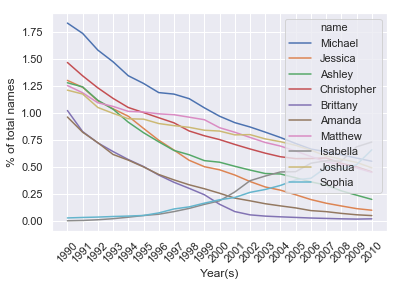

In [10]:
BabyNames().ChangeOfPopularity(fromYear=1990, toYear=2010,top=10)

In [11]:
BabyNames().Top5NamesPerYear(2017,)

C:\Users\shiva\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:154: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
C:\Users\shiva\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


Top Five Names for Births in 2017                                        \
                                   name count      name count      name count   
rank                                1.0   1.0       2.0   2.0       3.0   3.0   
state                                                                           
AK                                 Emma    56    Olivia    56     James    47   
AL                              William   398       Ava   358     James   315   
AR                                 Emma   176    Elijah   170    Olivia   155   
AZ                                 Emma   446      Liam   404  Isabella   400   
CA                                 Emma  2726       Mia  2588      Noah  2531   
CO                                 Liam   315    Oliver   297      Emma   292   
CT                               Olivia   230      Noah   222      Emma   219   
DC                                James    93     Henry    83   William    80   
DE                                Logan    64    Olivia    56       Ava    55   
FL                                 Liam  1352  Isabella  1306      Noah  1282   
GA                              William   685       Ava   667      Noah   618   
HI                                 Liam    78      Emma    73     Logan    64   
IA                               Oliver   210      Liam   180     Henry   179   
ID                               Oliver   115      Emma   105      Liam    99   
IL                                 Noah   775    Olivia   726      Emma   701   
IN                                 Emma   448    Olivia   391    Oliver   386   
KS                                 Emma   202    Olivia   182    Oliver   170   
KY                              William   302      Emma   290    Elijah   283   
LA                               Olivia   296       Ava   278      Noah   259   
MA                             Benjamin   492   William   421      Emma   393   
MD                                  Ava   341      Liam   341     Logan   333   
ME                            Charlotte    89    Oliver    86    Olivia    74   
MI                                 Emma   531       Ava   526      Liam   505   
MN                               Oliver   357   William   343     Henry   337   
MO                               Olivia   367       Ava   351   William   345   
MS                                  Ava   211   William   180      John   179   
MT                                James    59    Olivia    59   William    57   
NC                                  Ava   649   William   629      Noah   621   
ND                               Oliver    74      Emma    70     Henry    64   
NE                               Oliver   147      Emma   124      Liam   123   
NH                            Charlotte    95     Logan    78    Evelyn    74   
NJ                                 Emma   583      Liam   582    Olivia   561   
NM                                 Noah   129       Mia   107    Sophia   102   
NV                                 Liam   196      Emma   187       Mia   181   
NY                                 Liam  1427      Noah  1238    Olivia  1227   
OH                                 Emma   669       Ava   661      Liam   652   
OK                                 Emma   234    Olivia   199   William   199   
OR                               Oliver   229      Liam   216      Emma   208   
PA                                 Emma   778     Logan   722      Liam   718   
RI                            Charlotte    69      Emma    67     Lucas    64   
SC                              William   324       Ava   289      Noah   285   
SD                               Oliver    67      Owen    62   Lincoln    56   
TN                              William   526    Elijah   436       Ava   435   
TX                                 Emma  2302      Noah  1965       Mia  1882   
UT                               Oliver   297      Liam   265   William   247   
VA                                 Li

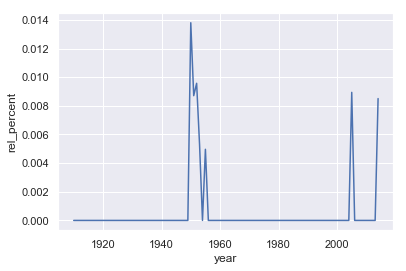

In [12]:
BabyNames().NamePopularityPlot(name='Unknown', yearRange=(1910,2015), state='IL', sex = 'F')


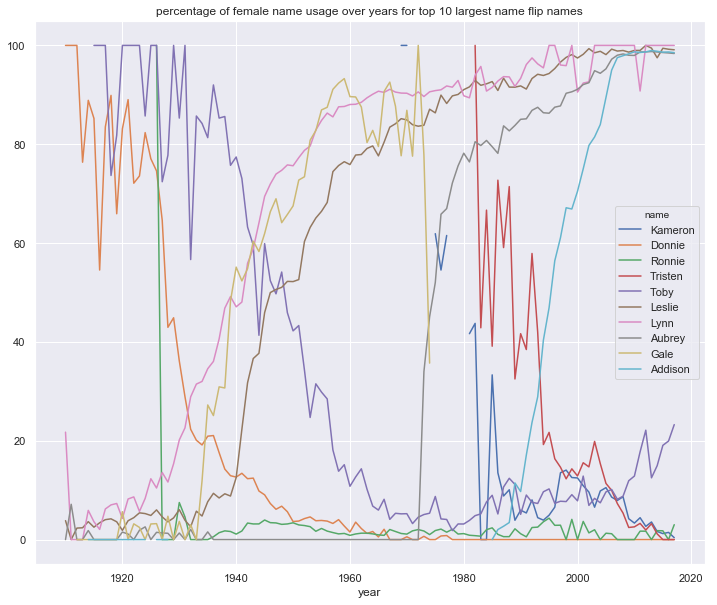

In [13]:
BabyNames().NameFlip(top=10)

### Insights from Baby Name dataset

#### Insight 1
###### Erraneous gender neutrality in Kansas

['Emily' 'Ethan' 'Hannah' 'Jacob' 'James' 'Madison' 'William']
Bar plot showing count of the name Emily split based on gender


C:\Users\shiva\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


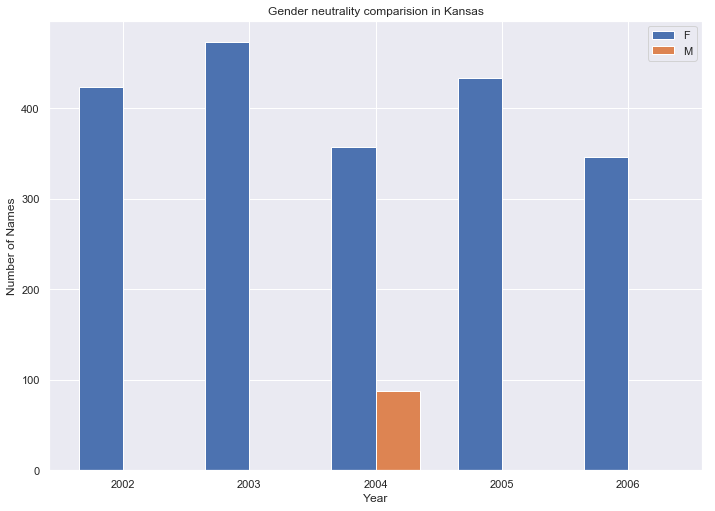

Bar plot showing count of the name Ethan split based on gender


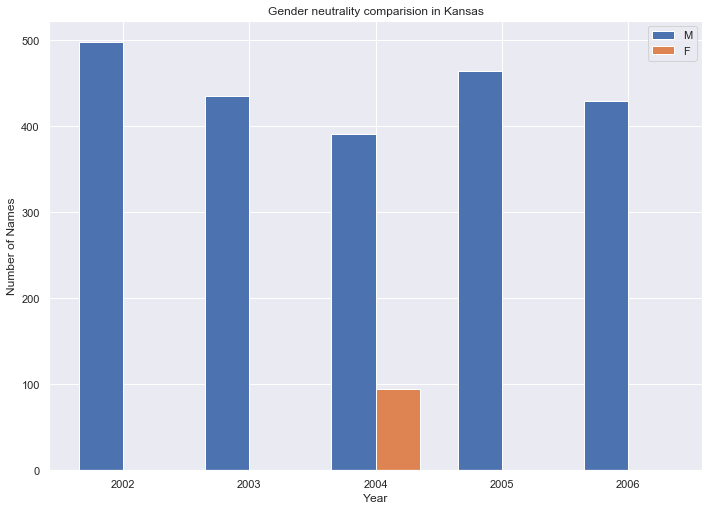

Bar plot showing count of the name Hannah split based on gender


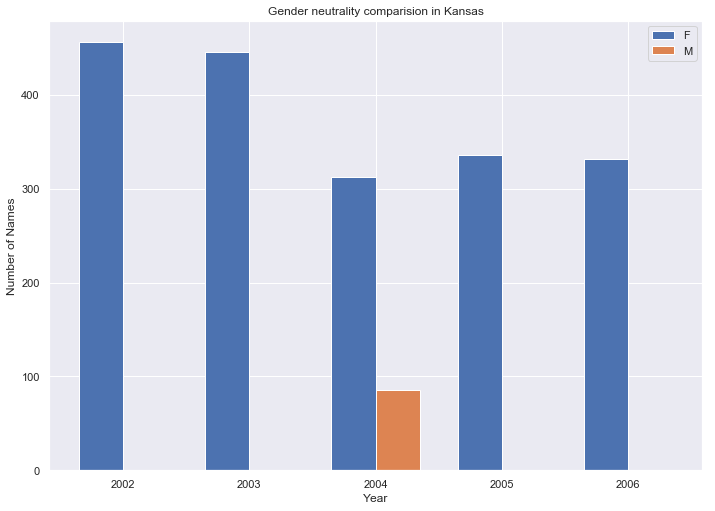

Bar plot showing count of the name Jacob split based on gender


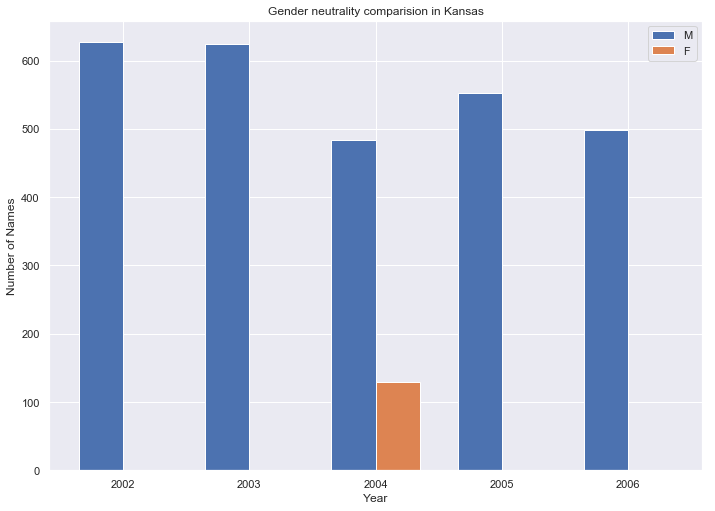

Bar plot showing count of the name James split based on gender


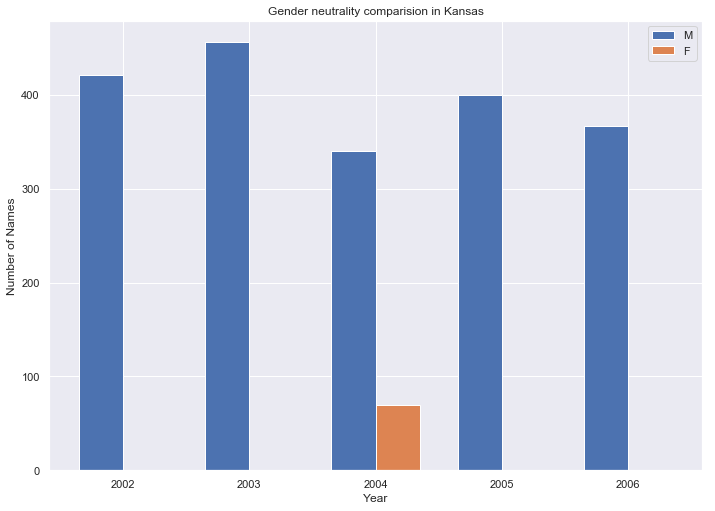

Bar plot showing count of the name Madison split based on gender


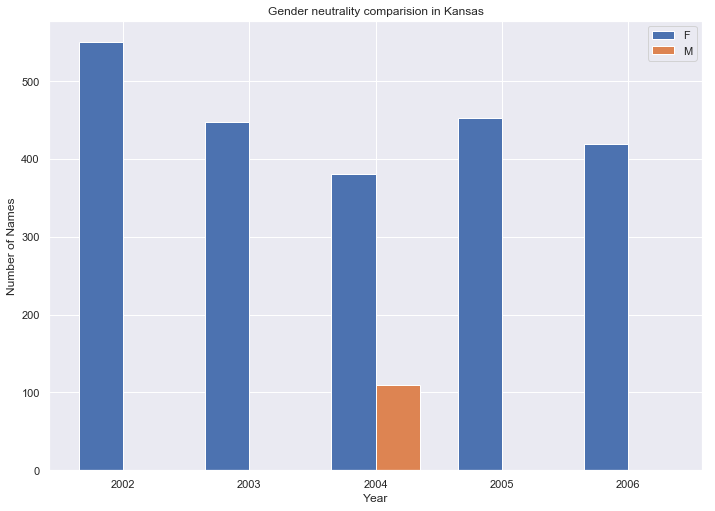

Bar plot showing count of the name William split based on gender


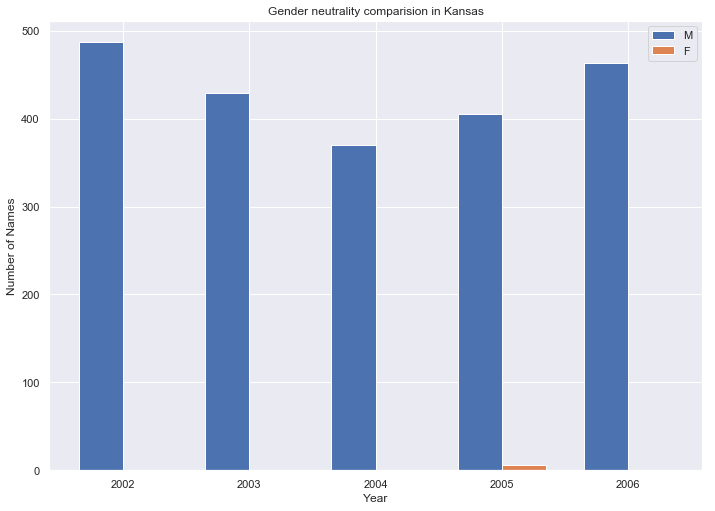

In [22]:
temp_data = state_name_df[(state_name_df['state'] == 'KY') & (state_name_df['year'] >= 2002) & (state_name_df['year'] <= 2006)]
temp_data2 = temp_data.groupby(['year','sex','name'], as_index=False)['count'].sum().sort_values(['name','year'])
temp_data3 = temp_data2[temp_data2['name'].isin(temp_data2.name[temp_data2['count'] > 400].unique())]
print(temp_data3.name.unique())
j = 0
for i in temp_data3.name.unique():
    print("Bar plot showing count of the name",i,"split based on gender")
    temp_data4 = temp_data3.loc[temp_data3['name'] == i]
    if temp_data4['sex'].iloc[0] == 'M':
        ref1 = 'M'
        ref2 = 'F'
        temp_data5 = temp_data4[temp_data4['sex'] == 'M']
        temp_data6 = temp_data4[temp_data4['sex'] == 'F']
    else:
        ref1 = 'F'
        ref2 = 'M'
        temp_data5 = temp_data4[temp_data4['sex'] == ref1]
        temp_data6 = temp_data4[temp_data4['sex'] == ref2]
    temp_data7 = temp_data5[['year','sex','name','count']]
    for x in range(temp_data7.shape[0]):
        for y in range(temp_data6.shape[0]):
            temp_data7['year'].iloc[x]
            temp_data6['year'].iloc[y]
            if temp_data7['year'].iloc[x] == temp_data6['year'].iloc[y]:
                temp_data7['count'].iloc[x] = temp_data6['count'].iloc[y]
            else:
                temp_data7['count'].iloc[x] = 0
    ind = np.arange(5) 
    width = 0.35       
    plt.bar(ind, temp_data5['count'], width, label=ref1)
    plt.bar(ind + width, temp_data7['count'], width,label=ref2)
    plt.xticks(ind + width / 2, ('2002', '2003', '2004', '2005', '2006'))
    plt.legend(loc='best')
    plt.xlabel('Year')
    plt.ylabel('Number of Names')
    plt.title('Gender neutrality comparision in Kansas')
    plt.show()

###### The above graphs show a plot for count of seven names in the city of Kansas for each year from 2002 to 2006 and is partitioned based on gender. It can be seen that, in 2004 alone some names which are generally considered as male names were recorded as female names and vice versa. Now this could have been just a name flip among genders, but the gender recorded for the same names before and after 2004 seem to not show any signs of name flips. So the baby name dataset seems to have misrepresented gender for babies born in Kansas in 2004.

#### Insight 3

###### A quick look at the popularity gained by the name Jordan which correlated with the popularity gain of a certain Michael Jordan who made his NBA debut in 1984

###### Popularity over the years for "Jordan"

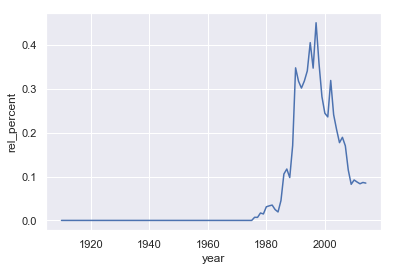

In [16]:
BabyNames().NamePopularityPlot(name='Jordan', yearRange=(1910,2015), state='IL', sex = 'F')

#### While Game of Thrones exponentially increased the popularity of the name "Arya", it also gave birth to new names like "Khaleesi"

###### Popularity over the years for "Arya"

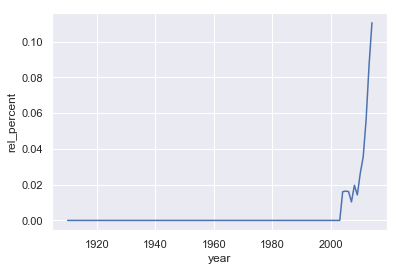

In [15]:
BabyNames().NamePopularityPlot(name='Arya', yearRange=(1910,2015), state='IL', sex = 'F')

###### Popularity over the years for "Khaleesi"

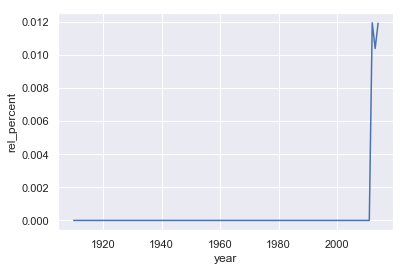

In [14]:
BabyNames().NamePopularityPlot(name='Khaleesi', yearRange=(1910,2015), state='IL', sex = 'F')

Using MySQL and the sample database “WORLD”, your tasks are:

    1. Translate the following SQL commands into Pandas library commands.
    2. Make sure to compare results
    3. Provide a description of what each SQL statement intends to do.

1.

select *
from country
where population > 50000000
order by population DESC limit 10

2.

select Continent, count(*) As Number_Countries, sum(population) As Population
from country
where population > 0
group by Continent
order by 1 ASC

3.

select city.Name As City, city.population
from city
inner join country ON city.CountryCode = country.code
where country.code = 'USA'
order by city.population DESC limit 10

4.

select country.Name, Language, (Percentage * population) / 100
from countrylanguage
inner join country on countrylanguage.CountryCode = country.code
where IsOfficial = True
order by 3 DESC limit 10

5.

select Language, sum((Percentage * population) / 100)
from countrylanguage
inner join country ON countrylanguage.CountryCode = country.code
group by Language
order by 2 desc limit 5


In [58]:
#Set up connection to local DB 

cnx = pymysql.connect(user='root', \
      password='password', \
      host= '127.0.0.1', \
      port=3306, \
      db='world', \
      autocommit=True)

In [57]:
# Load each table into dataframe

df_country = pd.read_sql_query('select * from Country',
                               con=cnx,index_col='Code')
df_city = pd.read_sql_query('select * from city',
                            con=cnx,index_col='ID')
df_countrylanguage = pd.read_sql_query('select * from countrylanguage',
                                       con=cnx,index_col=['CountryCode','Language'])

#Rename index for easier join conditions

df_countrylanguage.index.names = ['Code', 'Language']

    select *
    from country
    where population > 50000000
    order by population DESC limit 10

In [56]:
result = (df_country.loc[df_country['Population'] > 50000000]
              .sort_values(by=['Population'],ascending=False)
                  .head(10))
print(result)

                    Name      Continent                     Region  \
Code                                                                 
CHN                China           Asia               Eastern Asia   
IND                India           Asia  Southern and Central Asia   
USA        United States  North America              North America   
IDN            Indonesia           Asia             Southeast Asia   
BRA               Brazil  South America              South America   
PAK             Pakistan           Asia  Southern and Central Asia   
RUS   Russian Federation         Europe             Eastern Europe   
BGD           Bangladesh           Asia  Southern and Central Asia   
JPN                Japan           Asia               Eastern Asia   
NGA              Nigeria         Africa             Western Africa   

      SurfaceArea  IndepYear  Population  LifeExpectancy        GNP  \
Code                                                                  
CHN     9572900.0


    select Continent, count(*) As Number_Countries, sum(population) As Population
    from country
    where population > 0
    group by Continent
    order by 1 ASC

In [52]:
result = (df_country.loc[df_country['Population'] > 0]
              .groupby('Continent')
                  .agg({'Name' : ['count'],'Population' : ['sum']})
                      .sort_values(by = ['Continent'],ascending=True))
print(result)

               Name  Population
              count         sum
Continent                      
Africa           57   784475000
Asia             51  3705025700
Europe           46   730074600
North America    37   482993000
Oceania          27    30401150
South America    14   345780000



    select city.Name As City, city.population
    from city
        inner join country 
        ON city.CountryCode = country.code
    where country.code = 'USA'
    order by city.population DESC limit 10

In [53]:
#Join tables city and country
df_city_country = pd.merge(df_city,df_country, how = 'inner',left_on='CountryCode', right_on='Code')
result = df_city_country.loc[df_city_country['CountryCode'] == 'USA'].sort_values(by = ['Population_x'],ascending=False).head(10)
result = result[['Name_x', 'Population_x']]
result = result.rename(columns={"Name_x": "Name", "Population_x": "Population"})
result

,Name,Population
3792,New York,8008278
3793,Los Angeles,3694820
3794,Chicago,2896016
3795,Houston,1953631
3796,Philadelphia,1517550
3797,Phoenix,1321045
3798,San Diego,1223400
3799,Dallas,1188580
3800,San Antonio,1144646
3801,Detroit,951270



    select country.Name, Language, (Percentage * population) / 100
    from countrylanguage
        inner join country on countrylanguage.CountryCode = country.code
    where IsOfficial = True
    order by 3 DESC limit 10

In [54]:
#Join tables so language and populataion in same table
merged_countrylanguage = pd.merge(df_countrylanguage,df_country, left_index=True, right_index=True)
#Create new column for PercentPopulation = percentage * population / 100
PercentPopulation = merged_countrylanguage.Population * merged_countrylanguage.Percentage / 100
merged_countrylanguage['PercentPopulation'] = PercentPopulation
#Check where language is the official language and order by the top 10 based on PopPercent
result = merged_countrylanguage.loc[merged_countrylanguage['IsOfficial']=='T'].sort_values(by=['PercentPopulation'],ascending=False).head(10)
result[['Name', 'PercentPopulation']]

,,Name,PercentPopulation
Code,Language,,
CHN,Chinese,China,1.175353e+09
IND,Hindi,India,4.044511e+08
USA,English,United States,2.399437e+08
BRA,Portuguese,Brazil,1.658621e+08
RUS,Russian,Russian Federation,1.272448e+08
BGD,Bengali,Bangladesh,1.261844e+08
JPN,Japanese,Japan,1.255736e+08
MEX,Spanish,Mexico,9.106940e+07
DEU,German,Germany,7.501637e+07



    select Language, sum((Percentage * population) / 100)
    from countrylanguage
    inner join country ON countrylanguage.CountryCode = country.code
    group by Language
    order by 2 desc limit 5

In [55]:
#Join tables so language and populataion in same table
merged_countrylanguage = pd.merge(df_countrylanguage,df_country, left_index=True, right_index=True)
#Create new column for PercentPopulation = percentage * population / 100
PercentPopulation = merged_countrylanguage.Population * merged_countrylanguage.Percentage / 100
merged_countrylanguage['PercentPopulation'] = PercentPopulation
result = merged_countrylanguage.groupby('Language').agg({'PercentPopulation': 'sum'}).sort_values(by=['PercentPopulation'],ascending=False).head(5)
result

,PercentPopulation
Language,
Chinese,1.191844e+09
Hindi,4.056331e+08
Spanish,3.550295e+08
English,3.470779e+08
Arabic,2.338392e+08
